# Call Discogs API to get Wantlist

In [4]:
# imports 1.0
import requests
import pandas as pd

In [5]:
#get my discogs wantlist
def get_discog_wantlist_df(username):

    resp = requests.request(method="GET", url=f"https://api.discogs.com//users/{username}/wants")
    resp_json = resp.json()

    want_page_count = resp_json["pagination"]["pages"]
    current_page = 1
    want_records = []
    while current_page <= want_page_count:
        wants = resp_json["wants"]
        for w in wants:
            for k, v in w["basic_information"].items():
                w[k] = v
            want_records.append(w)
        if "next" in resp_json["pagination"]["urls"].keys():
            url = resp_json["pagination"]["urls"]["next"]
            current_page += 1

    return pd.DataFrame(want_records).drop("basic_information", axis=1)

username = "cyndercone"
wantlist_df = get_discog_wantlist_df(username)

In [6]:
wantlist_df.head()

,id,resource_url,rating,date_added,master_id,master_url,title,year,formats,labels,artists,thumb,cover_image,genres,styles
0,4259776,https://api.discogs.com/releases/4259776,0,2022-04-10T06:25:48-07:00,263608.0,https://api.discogs.com/masters/263608,Cerulean,2010,"[{'name': 'Vinyl', 'qty': '1', 'descriptions':...","[{'name': 'Anticon', 'catno': 'ABR0105', 'enti...","[{'name': 'Baths', 'anv': '', 'join': '', 'rol...",,,"[Electronic, Hip Hop, Rock, Funk / Soul, Folk,...","[Instrumental, Experimental]"
1,4645530,https://api.discogs.com/releases/4645530,0,2022-04-10T06:26:08-07:00,565246.0,https://api.discogs.com/masters/565246,Obsidian,2013,"[{'name': 'Vinyl', 'qty': '1', 'descriptions':...","[{'name': 'Anticon', 'catno': 'ABR0138', 'enti...","[{'name': 'Baths', 'anv': '', 'join': '', 'rol...",,,"[Electronic, Pop]","[Glitch, Hip Hop, Experimental, Electro]"
2,1275429,https://api.discogs.com/releases/1275429,0,2021-06-10T16:49:01-07:00,58824.0,https://api.discogs.com/masters/58824,Alopecia,2008,"[{'name': 'Vinyl', 'qty': '1', 'descriptions':...","[{'name': 'Anticon', 'catno': 'ABR0080 LP', 'e...","[{'name': 'Why?', 'anv': '', 'join': '', 'role...",,,"[Electronic, Hip Hop, Rock, Pop]","[Experimental, Cloud Rap]"
3,6665195,https://api.discogs.com/releases/6665195,0,2021-03-30T14:11:03-07:00,798641.0,https://api.discogs.com/masters/798641,Carrie & Lowell,2015,"[{'name': 'Vinyl', 'qty': '1', 'text': 'Clear'...","[{'name': 'Asthmatic Kitty Records', 'catno': ...","[{'name': 'Sufjan Stevens', 'anv': '', 'join':...",,,"[Folk, World, & Country]",[]
4,11193289,https://api.discogs.com/releases/11193289,0,2021-03-30T14:10:32-07:00,1273504.0,https://api.discogs.com/masters/1273504,"The Greatest Gift (Mixtape) (Outtakes, Remixes...",2017,"[{'name': 'Vinyl', 'qty': '1', 'text': 'Yellow...","[{'name': 'Asthmatic Kitty Records', 'catno': ...","[{'name': 'Sufjan Stevens', 'anv': '', 'join':...",,,"[Rock, Folk, World, & Country]",[Alternative Rock]


# Get Release Price History

In order to get the price history for a release, you visit https://www.discogs.com/sell/history/<release_id>. Discogs has a recaptcha mechanism to check if a human is making the request. For this project, I chose to copy a release ID from my wantlist, paste it into the url format, and manually extract the price history data. I looked into scraping this automatically with BeautifulSoup but I could not get around the recaptcha.

For this forecasting task, I got release data from
https://www.discogs.com/sell/history/108093 and saved the table to `ChemBros_ComeWithUs_2002.csv`

# Discogs record price predictor

In [16]:
# imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [8]:
# Load and clean data
df = pd.read_csv("ChemBros_ComeWithUs_2002.csv", parse_dates=True)
df = df.dropna()
df.iloc[0]
df = df.sort_values(by="Order Date")
df = df[["Order Date", "Price in your currency"]]
df['Order Date'] = pd.to_datetime(df['Order Date'])

# remove "$"
price_in_currency = []
for _, r in df.iterrows():
    p = ''
    for character in r['Price in your currency']:
        if character.isdigit() or character==".":
            p += character
    price_in_currency.append(float(p))
    
df['Price in your currency'] = price_in_currency



In [17]:
df = X.rename(columns={'Order Date': 'ds', 'Price in your currency': 'y' })


<AxesSubplot:xlabel='ds'>

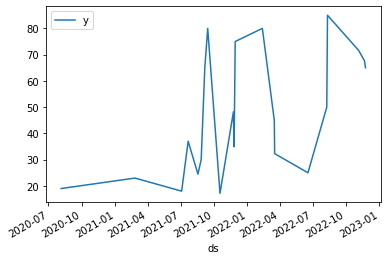

In [18]:
df.plot(x='ds', y='y')

In [51]:
# Need to interpolate so there is a record for each day, every day has a value
df = df.set_index('ds').resample('D').mean()
df['y'] = df_interpol['y'].interpolate()
df = df.reset_index()

In [53]:
# make train/test split
num_train_records = round(len(df) * .7)
train = df.iloc[:num_train_records]
test = df.iloc[num_train_records:]

In [57]:
# Fit model
m=Prophet()
m.fit(train)

# Forecast into future
num_future_periods = len(df)-num_train_records
future=m.make_future_dataframe(periods=num_future_periods,)
forecast=m.predict(future)
forecast.head()

08:26:15 - cmdstanpy - INFO - Chain [1] start processing
08:26:15 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-08-05,19.607040,6.246757,32.912081,19.607040,19.607040,-0.102206,-0.102206,-0.102206,-0.102206,-0.102206,-0.102206,0.0,0.0,0.0,19.504834
1,2020-08-06,19.614905,6.085461,33.733334,19.614905,19.614905,0.091256,0.091256,0.091256,0.091256,0.091256,0.091256,0.0,0.0,0.0,19.706162
2,2020-08-07,19.622771,4.520739,32.596465,19.622771,19.622771,-0.107912,-0.107912,-0.107912,-0.107912,-0.107912,-0.107912,0.0,0.0,0.0,19.514858
3,2020-08-08,19.630636,5.081505,32.786531,19.630636,19.630636,-0.033933,-0.033933,-0.033933,-0.033933,-0.033933,-0.033933,0.0,0.0,0.0,19.596703
4,2020-08-09,19.638501,5.920582,34.007747,19.638501,19.638501,0.026567,0.026567,0.026567,0.026567,0.026567,0.026567,0.0,0.0,0.0,19.665068


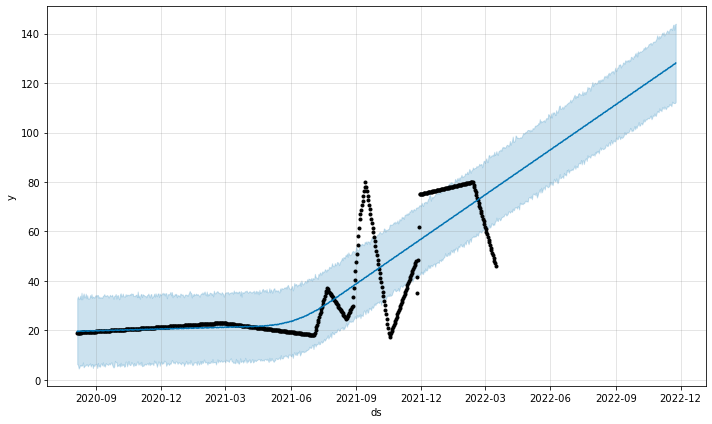

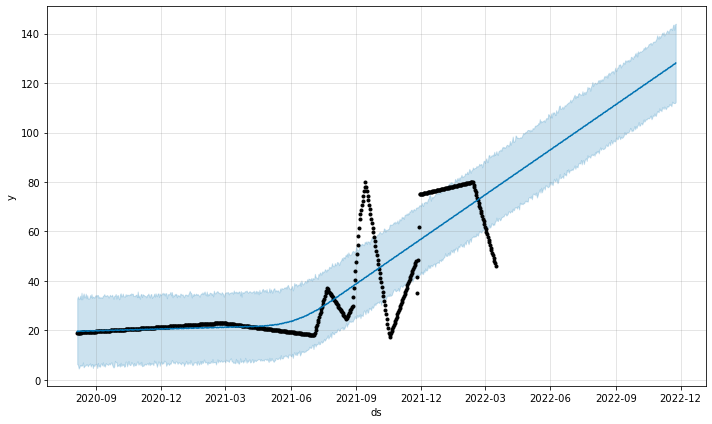

In [58]:
# Prophet plots the observed values of time series(black dots),the forecasted values(blue lines) and the uncertainty intervals of our forecasts(blue shaded region)

m.plot(forecast, uncertainty=True)

In [59]:
future['ds'].min()

Timestamp('2020-08-05 00:00:00')

<AxesSubplot:xlabel='ds'>

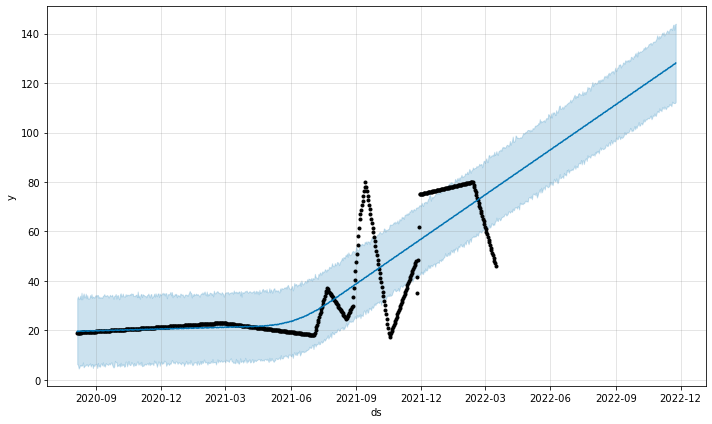

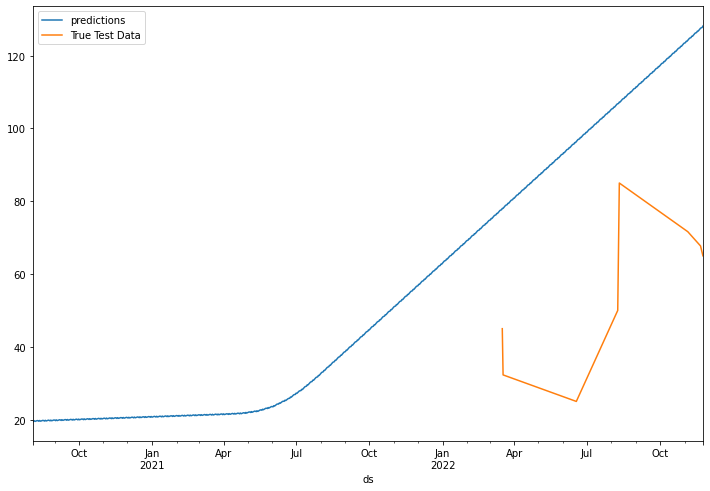

In [82]:
# comparing true values vs predictions
m.plot(forecast)
ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=(future['ds'].min(),future['ds'].max()))

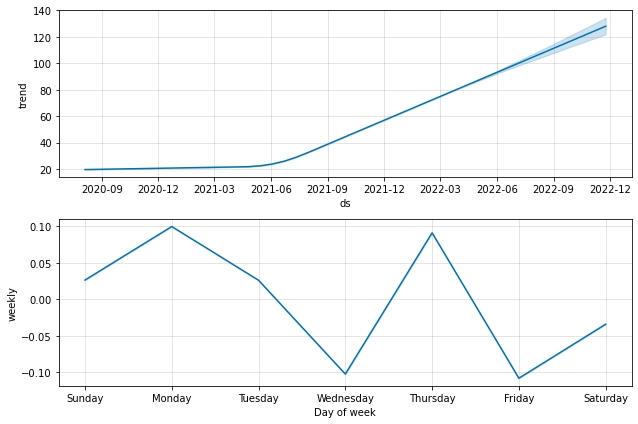

In [61]:
# plot components - referenced in article 
fig=m.plot_components(forecast)

In [78]:
# Performance metrics, cross validation 
# Initial training period.
initial= 365
initial= str(initial)+' days'

#Period length that we perform the cross validation for.
period= 10
period=str(period)+' days'

#Horizon of prediction essentially for each fold.
horizon = 20
horizon=str(horizon)+' days'

fb_cv=cross_validation(m,initial=initial,period=period,
horizon=horizon)


# Performance Metrics of fb_cv
performance_metrics(fb_cv)

  0%|          | 0/21 [00:00<?, ?it/s]

08:36:56 - cmdstanpy - INFO - Chain [1] start processing
08:36:57 - cmdstanpy - INFO - Chain [1] done processing
08:36:57 - cmdstanpy - INFO - Chain [1] start processing
08:36:57 - cmdstanpy - INFO - Chain [1] done processing
08:36:57 - cmdstanpy - INFO - Chain [1] start processing
08:36:57 - cmdstanpy - INFO - Chain [1] done processing
08:36:57 - cmdstanpy - INFO - Chain [1] start processing
08:36:57 - cmdstanpy - INFO - Chain [1] done processing
08:36:57 - cmdstanpy - INFO - Chain [1] start processing
08:36:57 - cmdstanpy - INFO - Chain [1] done processing
08:36:58 - cmdstanpy - INFO - Chain [1] start processing
08:36:58 - cmdstanpy - INFO - Chain [1] done processing
08:36:58 - cmdstanpy - INFO - Chain [1] start processing
08:36:58 - cmdstanpy - INFO - Chain [1] done processing
08:36:58 - cmdstanpy - INFO - Chain [1] start processing
08:36:58 - cmdstanpy - INFO - Chain [1] done processing
08:36:59 - cmdstanpy - INFO - Chain [1] start processing
08:36:59 - cmdstanpy - INFO - Chain [1]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,273.150013,16.527251,13.490346,0.325808,0.223801,0.267592,0.357143
1,3 days,304.994180,17.464083,14.439678,0.334880,0.228707,0.282203,0.333333
2,4 days,333.685055,18.267048,15.095949,0.340970,0.218590,0.291596,0.333333
3,5 days,350.843479,18.730816,15.458887,0.345860,0.204896,0.296990,0.309524
4,6 days,371.189711,19.266284,15.820085,0.352143,0.217866,0.302299,0.309524
5,7 days,394.857073,19.871011,16.175259,0.359993,0.241424,0.307509,0.333333
6,8 days,419.413062,20.479577,16.542493,0.371579,0.253684,0.313467,0.333333
7,9 days,441.035664,21.000849,16.870144,0.385781,0.265298,0.319101,0.357143
8,10 days,461.748374,21.488331,17.320082,0.406216,0.288674,0.327775,0.380952
9,11 days,481.148411,21.935095,17.722873,0.427529,0.309014,0.335026,0.357143


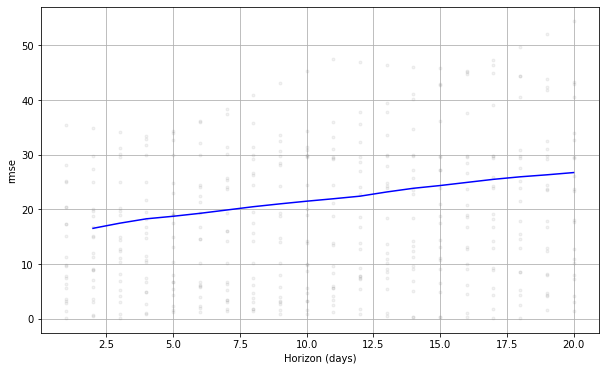

In [79]:
plot_cross_validation_metric(fb_cv,'rmse');


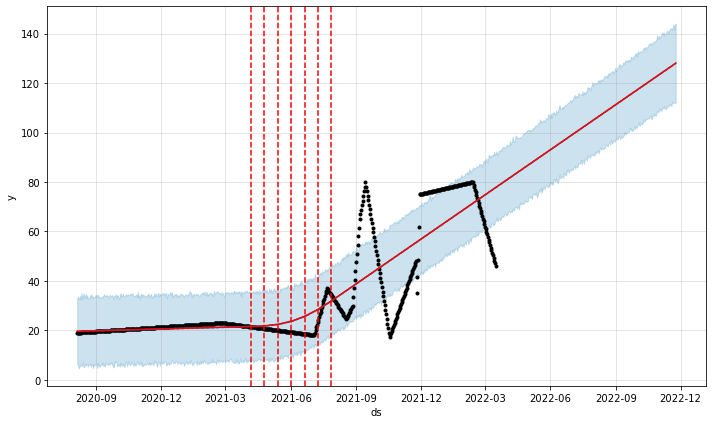

In [81]:
# changing trend points, red lines are major inflection points in trend line
from prophet.plot import add_changepoints_to_plot
fig=m.plot(forecast)
a=add_changepoints_to_plot(fig.gca(),m,forecast)